# Project: Customer Segmentation

## 1. Problem statement

In this project, you will solve a real business problem in the field of marketing. You will have to segment customers based on their purchasing power, order frequency, and the length of time since their last order, and determine the optimal strategy for interacting with them.
<center> <img src=https://salesupnow.ru/storage/app/media/pipeople.png align="right" width="300"/> </center>

Marketing is an integral part of any business. To increase a company's profits, it is important to understand your customer, their wishes, and preferences. With the advent of e-commerce, or online sales, it has become much easier to collect customer data, analyze it, find patterns, and implement marketing campaigns.

Most online stores use web analytics tools to track page views, visitor volume and behavior, and bounce rate. But a report from Google Analytics or a similar system may not be enough to fully understand how customers interact with the site. It is important for companies to be able to quickly and accurately respond to changes in customer behavior by creating tools that detect these changes in near real time.

Machine learning helps the search engine analyze a huge amount of data about platform visitors, recognize behavior patterns of professional buyers, determine the category of customers (e.g. loyal/promising/newbies/sleeping/gone) and choose the right strategy for interacting with them.

It is also worth noting that companies using machine learning on their e-commerce platforms can constantly improve the efficiency of business processes: customize the product selection personally for each customer and offer a favorable price in accordance with the customer's budget, etc. This task falls under the category of building recommender systems, which will be discussed in the next section of our course.

**Business task:** segment existing customers, interpret these segments and determine a strategy for interacting with them.

**Technical task for you as a Data Science specialist:** build a customer clustering model based on their purchasing power, order frequency and the time since their last purchase, and determine the profile of each cluster.

**Main project goals:**
1. Pre-process the data set.
2. Conduct exploratory data analysis and identify key patterns.
3. Form product and customer categories.
4. Build several machine learning models that solve the customer clustering problem, determine the number of clusters and interpret them.
5. Design a process for predicting the customer interest category and test your model on new customers.

## 2. Getting to know the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

sys.path.append('../../')

The first thing we need to do is understand what data we will be working with and perform basic pre-processing of the data, converting the features into the formats required for further work.

First, let's get to know our data:

In [204]:
data = pd.read_csv(
    "../../data/Project6_customer_segmentation_project.csv", 
    encoding="ISO-8859-1", 
    dtype={'CustomerID': str,'InvoiceNo': str}
)
print('Data shape:', data.shape)
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


So, we have data on more than half a million transactions. Each of them is described by the following attributes:

* InvoiceNo — invoice number (a unique nominal six-digit number assigned to each transaction; the letter "C" at the beginning of the code indicates that the transaction is canceled);
* Stock Code — product code (a unique five-digit integer assigned to each individual product);
* Description — product name;
* Quantity — the quantity of each product per transaction;
* InvoiceDate — date and time of invoice/transaction;
* UnitPrice — unit price in pounds sterling;
* CustomerID — customer identifier (a unique five-digit number, uniquely assigned to each customer);
* Country — the name of the country in which the customer lives.

Let's analyze the table structure.

### Task 2.1
How many columns in the data are encoded with numeric types (int/float)?

In [205]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB


### Task 2.2
Select the columns that have at least one blank:
* InvoiceNo
* StockCode
* Description
* CustomerID
* Country

In [206]:
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The columns "Description" and "CustomerID" have blank values.

### Task 2.3
Judging by the task description, we should have been provided with data for a yearly period - let's check if this is true.

Convert the InvoiceDate column to datetime format.
Indicate the time period for which the data is provided:

* 2010-12-01 to 2011-12-09
* 2011-12-01 to 2012-12-09
* 2010-01-01 to 2011-01-09
* 2020-12-01 to 2021-12-09

In [207]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
print('Period start:', data['InvoiceDate'].min())
print('Period end:', data['InvoiceDate'].max())

Period start: 2010-12-01 08:26:00
Period end: 2011-12-09 12:50:00


Data is provided for the period 2010-12-01 to 2011-12-09.

### Task 2.4

1) What is the maximum quantity of goods in an order (Quantity)? Give the answer as an integer.

2) What is the minimum quantity of goods in an order (Quantity)? Give the answer as an integer.

3) How much does the cheapest item cost according to the data (excluding items with negative value)?

In [208]:
goods_counts_in_order = data.groupby('InvoiceNo')['Quantity'].agg('sum')

# 1
print('Max quantity of goods in order:', goods_counts_in_order.sort_values(ascending=False).iloc[0])

# 2
print('Min quantity of goods in order:', goods_counts_in_order.sort_values(ascending=True).iloc[0])

# 3
print('Cheapest not negative item price:', data[data['UnitPrice']>=0]['UnitPrice'].min())

Max quantity of goods in order: 80995
Min quantity of goods in order: -80995
Cheapest not negative item price: 0.0


### Task 2.5
1) How many unique customers purchased products during the dataset period?

2) How many unique countries are contained in the Country column (excluding the special code 'Unspecified', which denotes an unspecified country)?

3) Specify the identifier of the most popular product (StockCode):
* 85123A
* 64812
* 51242
* 24151B

In [209]:
# 1
print('Number of unique customers:', len(set(data['CustomerID'])) - 1)

# 2
print('Number of unique countries:', len(data['Country'].unique()) - 1)

# 3
print('The most popular product:', 
      data.groupby('StockCode')['StockCode'].agg('count').sort_values(ascending=False).index[0]
)

Number of unique customers: 4372
Number of unique countries: 37
The most popular product: 85123A


## 3. Preprocessing and data cleaning

At this stage, we need to prepare our dataset for further modeling by cleaning the data.

### Task 3.1
Let's start with blanks.

1) How many missing values ​​are there in the table?

2) Blands in the customer ID and product description columns indicate incorrect/incomplete transactions. Delete the rows containing blanks in these columns. How many rows are left in the table?

In [210]:
# 1
print('Number of missing values:', data.isnull().sum().sum())

# 2
data = data.dropna(how='any')
print('The number of remaining rows:', data.shape[0])

Number of missing values: 136534
The number of remaining rows: 406829


### Task 3.2
Following the gaps, we check for duplicates.

1) How many completely duplicate records are there in the table?

2) Remove duplicates from the table. How many rows are left?

In [211]:
# 1
duplicates = data.duplicated()
print('Number of duplicates:', duplicates.sum())

# 2
data = data.drop_duplicates()
print('Number of not duplicates:', data.shape[0])

Number of duplicates: 5225
Number of not duplicates: 401604


Earlier we noticed that there are negative values ​​in the column with the quantity of goods. Let's figure out where they come from. Let's output the first 5 rows of the table in which the Quantity column is less than 0.

In [212]:
negative_quantity = data[(data['Quantity']<0)]
print('Count of entries with a negative number:', negative_quantity.shape[0])
negative_quantity.head()

Count of entries with a negative number: 8872


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


### Task 3.3
Let's check that all records from the table with a negative quantity of goods are indeed return transactions. If a transaction is not a return, but contains a negative quantity of goods, this will be a reason to consider it an outlier.

How many transactions from the negative_quantity table do not contain a return indicator in the order number?

In [213]:
print('Number of negative quantity in not returns:', 
      data[~data['InvoiceNo'].str.startswith('C') & data['Quantity']<0].shape[0]
)

Number of negative quantity in not returns: 0


Let's take a closer look at returns. Currently, each unique product has a separate row in the table - this makes it difficult to determine the total number of returns.

To calculate the number of returns, you first need to determine how many unique products are specified in the transaction (basket) for each unique "customer-order" pair:

In [214]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


### Task 3.4
Add an order cancellation flag (order_canceled) to the auxiliary table nb_products_per_basket: it is equal to 1 if the transaction is a return, and 0 otherwise.

What percentage of orders in the table are returns? Give your answer as an integer.

In [215]:
nb_products_per_basket['order_canceled'] =\
    nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x.startswith('C') else 0)
nb_products_per_basket['order_canceled'].value_counts(normalize=True)

order_canceled
0    0.835331
1    0.164669
Name: proportion, dtype: float64

Let's take a closer look at the cancelled orders:

In [216]:
nb_products_per_basket[nb_products_per_basket['order_canceled']==1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Let's find in the table with all transactions, records belonging to the client with the identifier 12346:

In [217]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


So here is an example of an order-cancel pair. Notice the StockCode, UnitPrice, CustomerID and Quantity columns, compare them for the two transactions.

### Task 3.5
We put a hypothesis: for each cancelled transaction in the database (data table), there is an analogue with the same product code, customer ID and the opposite value of the product quantity.

* Is the hypothesis correct?
* Yes, it is correct

In [218]:
cancelled_orders = data.merge(
    nb_products_per_basket[nb_products_per_basket['order_canceled']==1],
    on=['CustomerID', 'InvoiceNo']
)
print('Number of transactions:', cancelled_orders.shape[0])
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']
cancelled_having_original = cancelled_orders.merge(data, on=['CustomerID', 'StockCode', 'Quantity'])
print('Number of cancelled transactions having an original order:', cancelled_having_original.shape[0])

Number of transactions: 8872
Number of cancelled transactions having an original order: 5939


The hypothesis is not correct because not for each cancelled transactions there is an original not cancelled transaction.

Let's give a counter-example where our previous hypothesis "stumbled". Let's look at the client with the ID 14527:

In [219]:
data[(data['CustomerID'] == '14527')].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Pay attention to the first line, which contains order C536379 with a cancellation flag - you will not find any opposite analogs in terms of the number of goods. The reason lies in the type of goods: this product is designated as a discounted product (StockCode), and, apparently, there are no analogs with a positive number of goods in the order for such transactions. Let's take this observation into account for the future.

### Task 3.6
We propose a new hypothesis: for each cancelled transaction in the database (data table), there is an analogue with the same product code, customer ID and the opposite value of the product quantity, if the product is not subject to discounts.

Is the hypothesis correct?
* Yes, it is correct
* No, it is not correct

In [220]:
cancelled_orders = cancelled_orders[cancelled_orders['StockCode'] != 'D']
print('Number of not discounted cancelled transactions:', cancelled_orders.shape[0])
cancelled_having_original = cancelled_orders.merge(data, on=['CustomerID', 'StockCode', 'Quantity'])
print('Number of cancelled transactions having an original order:', cancelled_having_original.shape[0])

Number of not discounted cancelled transactions: 8795
Number of cancelled transactions having an original order: 5939


The hypothesis is not correct because not for each not discounted cancelled transactions there is an original not cancelled transaction.

Let's see where our problem lies. As a counter-example, we will provide transactions related to the client with the ID 15311 and the product with the code 35004C:

In [221]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* On the first line we see an order with a cancellation (the order number starts with the character C). However, the question arises: for which order did this cancellation come, because there are no earlier transaction records related to this customer.
The answer is that the customer's purchase order for this product was received before December 2010, and this data is not in our table. This is a very common problem that arises in almost any work with transactions: there is only a fragment of the general data, but it is unknown what preceded this fragment.

* The next two lines show that the customer can cancel not the entire order, but only a part of it (on December 5, the customer buys 12 units of goods, and on December 8, issues a return for only one unit of goods). We must take this into account for the future

So, now we know all the features of order cancellations. When segmenting customers, we will determine their purchasing power, and for this it is very important to take into account product returns. Therefore, let's create a QuantityCanceled attribute in the transaction data, which will indicate the quantity of goods subsequently returned for each transaction.

Let's discuss right away that we will not take into account complex edge cases:
1. A cancelled transaction does not have an opposite one (there were no purchase transactions for the return transaction).
2. The quantity of returned goods in the return transaction is greater than the quantity of goods specified in any of the individual purchase transactions (this is the case when a customer made several orders for the same goods, and then issued a return for all goods at once).

In [222]:
def get_quantity_canceled(data):
    # Initialize Series to the same length as the table columns, with zeros
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Create a DataFrame from all counterparties
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # The return transaction has no counterparty - we do nothing
        if (df_test.shape[0] == 0): 
            continue
        # A return transaction has exactly one counterparty.
        # Add the quantity cancelled to the QuantityCanceled column
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # The return transaction has multiple counterparties
        # We set the quantity of the cancelled product in the QuantityCanceled column for that purchase transaction,
        # in which the quantity of goods > -(the quantity of goods in the return transaction)
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

data['QuantityCanceled'] = get_quantity_canceled(data)

### Task 3.7
Calculate the total number of cancelled products in the QuantityCanceled column.

In [223]:
print('Total number of cancelled products:', data['QuantityCanceled'].sum())

Total number of cancelled products: 245266.0


## Task 3.8
Now that we have dealt with return transactions, we will no longer need them.

Delete from the table the transactions having a negative quantity of goods.

How many records are left?

In [224]:
data = data[data['Quantity'] >= 0]
print('Number of records with a non-negative quantity:', data.shape[0])

Number of records with a non-negative quantity: 392732


The next problem is special types of transactions. For example, we have already seen that for discounted products the StockCode attribute is designated as 'D'. Let's check if there are other special codes.

### Task 3.9
Use regular expressions to find product codes (StockCode) that start with Latin letters (codes may contain numbers).

Hint: You can organize a search for substrings in a column using str.contains(). Use the string '^[a-zA-Z]+' as a search pattern. Set the regex parameter to True.

1) How many unique special transaction types did you manage to find?

Special operations do not characterize our customers, so we do not need such records. Remove all special transactions from the table.

2) How many records are left?

In [225]:
# 1
special_operations = data['StockCode'].str.contains('^[a-zA-Z]+', regex=True)
print('Unique special transaction types:', data[special_operations]['StockCode'].unique())

# 2
data = data[~special_operations]
print('Number of transactions after exclusion of special operations:', data.shape[0])

Unique special transaction types: ['POST' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']
Number of transactions after exclusion of special operations: 391183


### Task 3.10
Earlier, when looking at the descriptive statistics, we saw that some products had a price of £0.

1) In how many transactions was the unit price of the product 0?

2) There were less than 1% of such transactions, so we can simply get rid of them. Remove such transactions from the table. How many records are left?

In [226]:
# 1
print('Number of 0-price transactions:', data[data['UnitPrice'] == 0].shape[0])

# 2
data = data[data['UnitPrice'] != 0]
print('Number of transactions after exclusion of 0-price transactions:', data.shape[0])

Number of 0-price transactions: 33
Number of transactions after exclusion of 0-price transactions: 391150


In [233]:
# Save intermediate data state
data.to_csv('Project6_customer_segmentation_project_cleaned.csv', index=False)

## 4. Exploratory data analysis

Now let's do some exploratory data analysis and examine the transactions.

We have the following tasks:
* understand which countries' customers buy more and more often;
* find out if there is seasonality in sales (when they buy more often);
* create new features that will be needed later when forming a dataset about customers.

In [31]:
# Load intermediately saved data
data = pd.read_csv('Project6_customer_segmentation_project_cleaned.csv')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0.0
...,...,...,...,...,...,...,...,...,...
391145,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,0.0
391146,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,0.0
391147,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,0.0
391148,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,0.0


### Task 4.1
First, let's find out which countries the customers live in.

Plot a graph showing the number of customers in each country. Note that we need unique customers.

Which country has the largest number of customers?

* United Kingdom
* Germany
* France
* Netherlands
* Ireland (EIRE)
* Australia (Australia)

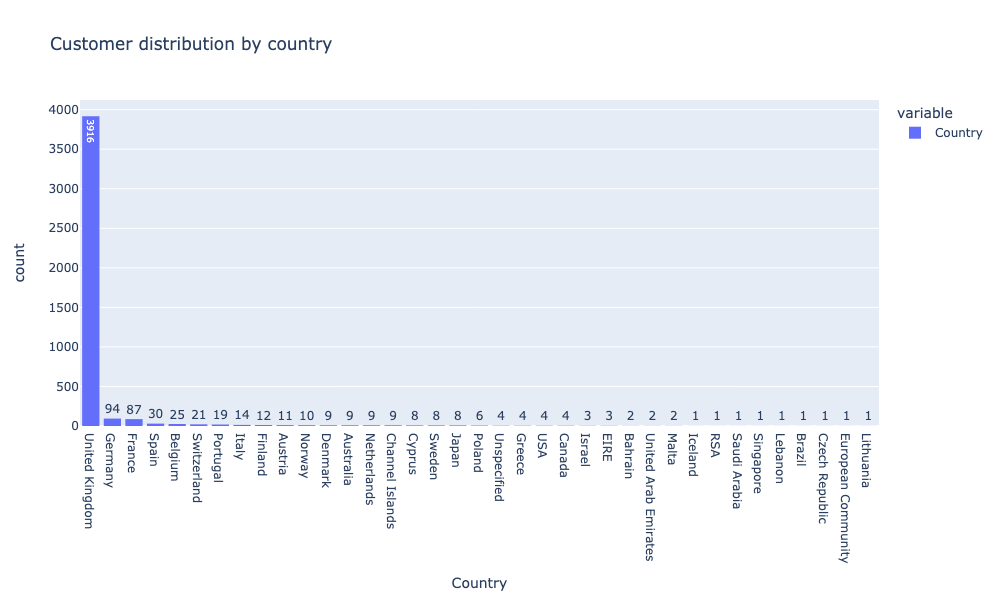

In [32]:
data_countries = data.groupby(['CustomerID', 'Country'], as_index=False).agg('count')['Country']

fig = px.histogram(
    data_countries,
    width=1000,
    height=600,
    title='Customer distribution by country',
    text_auto=True
).update_layout(
    xaxis_title='Country'
).update_xaxes(
    categoryorder="total descending"
)
fig.show('png')

United Kingdom has the largest number of customers.

### Task 4.2
We looked at the distribution of customers by country. What about orders?

Build a visualization and highlight the top 3 countries by the number of incoming orders.

* United Kingdom
* Germany
* France
* Netherlands
* Ireland (EIRE)
* Australia (Australia)

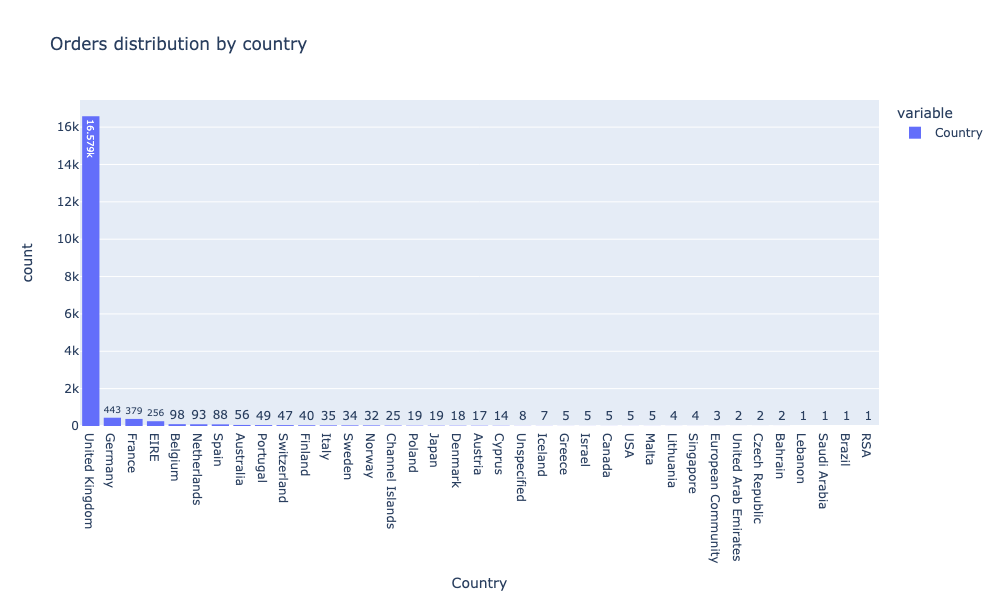

In [33]:
data_countries = data.groupby(['InvoiceNo', 'Country'], as_index=False).agg('count')['Country']

fig = px.histogram(
    data_countries,
    width=1000,
    height=600,
    title='Orders distribution by country',
    text_auto=True
).update_layout(
    xaxis_title='Country'
).update_xaxes(
    categoryorder="total descending"
)
fig.show('png')

United Kingdom, Germany and France have the largest number of orders.

### Task 4.3
Let's add the total price of an order to the dataset, let's call it TotalPrice.
The total price of an order is calculated as:

**total price = unit price * (number of items in the order - number of returned items).**

What is the average total cost of orders? Give your answer in pounds sterling and round to the nearest whole number.

In [35]:
data['total_price'] = data['UnitPrice']*(data['Quantity'] - data['QuantityCanceled'])

print('Average total price of orders:', data['total_price'].mean().round())

Average total price of orders: 21.0


### Task 4.4

Build a visualization and highlight the top 3 countries, clients from which bring the company the most revenue:

* United Kingdom
* Germany
* France
* Netherlands
* Ireland (EIRE)
* Australia (Australia)

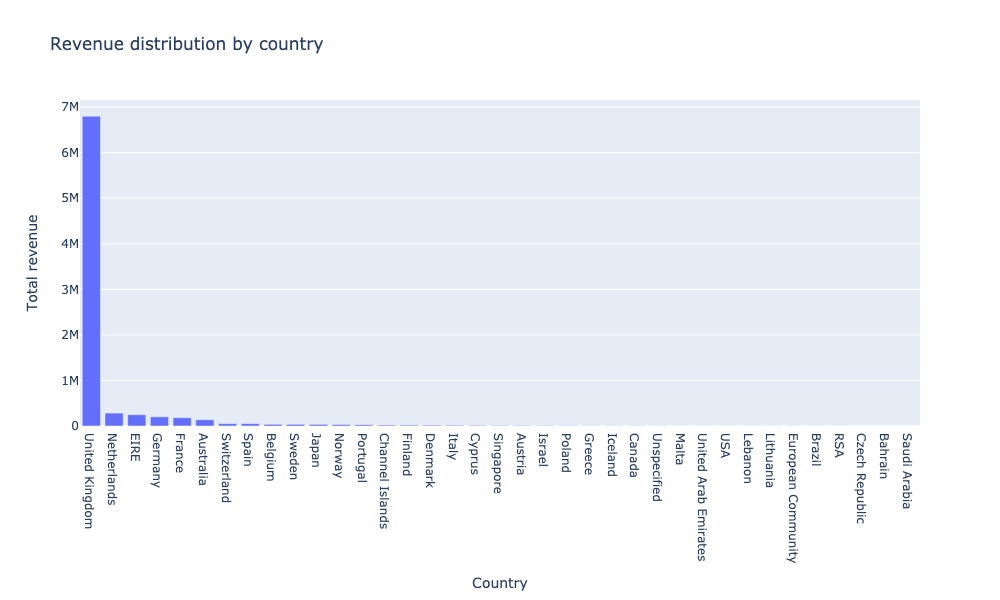

In [23]:
data_revenue = (
    data.groupby("Country", as_index=False)["total_price"]
    .agg("sum")
    .sort_values("total_price", ascending=False)
)

fig = px.bar(
    data_revenue,
    x='Country',
    y='total_price',
    width=1000,
    height=600,
    title='Revenue distribution by country'
).update_layout(
    yaxis_title='Total revenue'
)
fig.show('png')

United Kingdom, Netherlands and Ireland bring the highest revenue.

### Task 4.5
Add the month, day of the week, and hour of purchase to the transaction table.

Build a visualization that reflects the distribution of total revenue from orders by month. Indicate the number of the most profitable month for the company. Suggest why this happens.

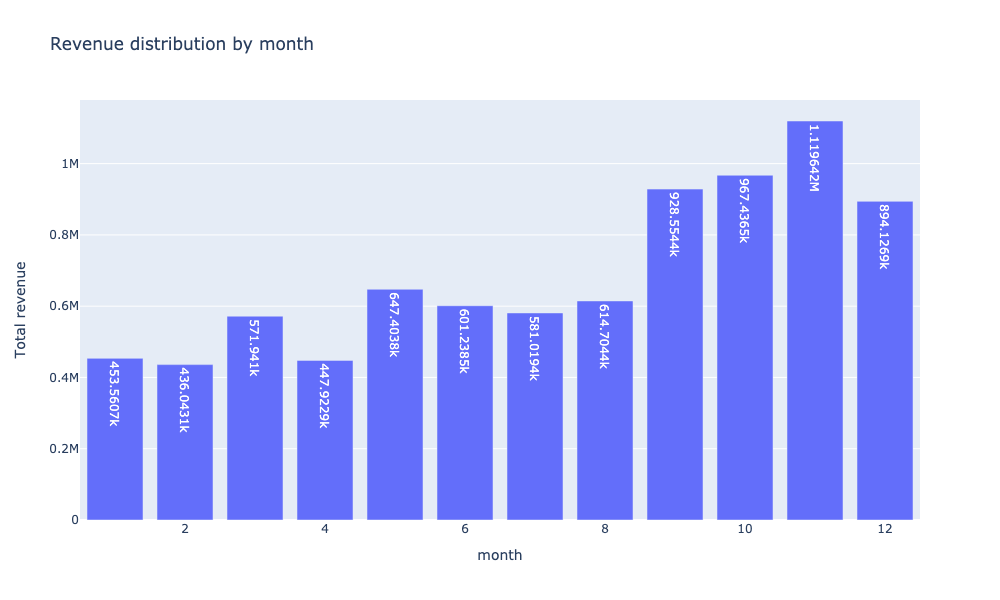

In [43]:
data['month'] = data['InvoiceDate'].dt.month
data['day_of_week'] = data['InvoiceDate'].dt.day_of_week
data['hour'] = data['InvoiceDate'].dt.hour

data_month = (
    data.groupby('month', as_index=False)['total_price']
    .agg('sum')
)

fig = px.bar(
    data_month,
    x='month',
    y='total_price',
    width=1000,
    height=600,
    title='Revenue distribution by month',
    text_auto=True
).update_layout(
    yaxis_title='Total revenue'
)
fig.show('png')

The most profitable month is November. The reason for that might be the preparation for the Christmas season.

### Task 4.6
Build a visualization of the number of orders for each day of the week. Indicate the day of the week on which, according to the data, no orders were made:
* Monday
* Tuesday
* Wednesday
* Thursday
* Friday
* Saturday
* Sunday

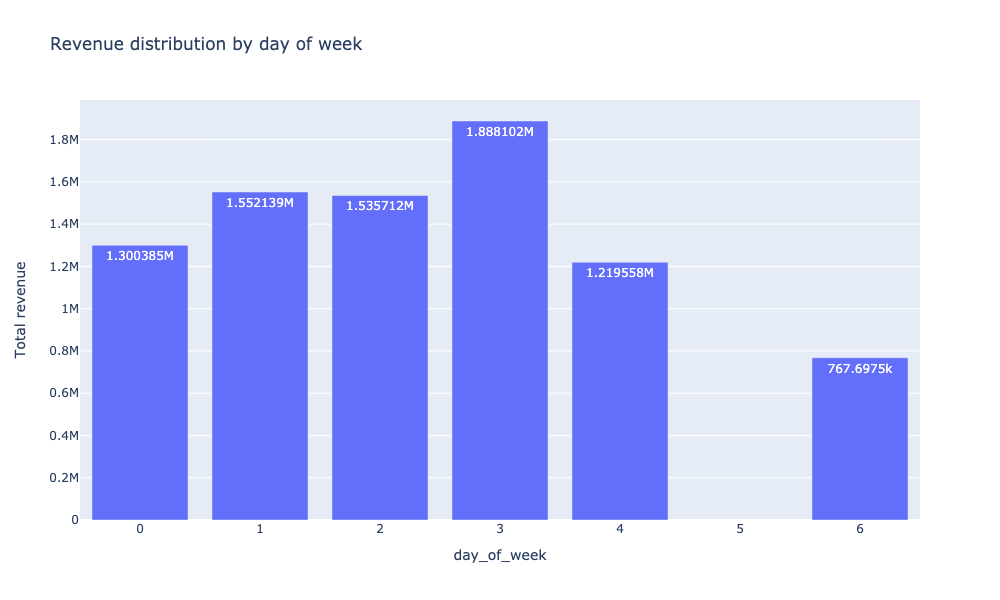

In [47]:
data_day_of_week = (
    data.groupby('day_of_week', as_index=False)['total_price']
    .agg('sum')
)

fig = px.bar(
    data_day_of_week,
    x='day_of_week',
    y='total_price',
    width=1000,
    height=600,
    title='Revenue distribution by day of week',
    text_auto=True
).update_layout(
    yaxis_title='Total revenue'
)
fig.show('png')

No orders have been done on Saturdays.

### Task 4.7
Select the date from the transaction time attribute.
Group the data by transaction dates and hours and find the number of orders for each day-hour. Then find the average number of daily orders in each hour.

Build a visualization that reflects the distribution of the average number of daily orders by time of day (transaction hour).

Select the correct statements:
* Most orders are made during the daytime in the interval from 18 to 20 hours
* Most orders are made in the evening in the interval from 10 to 15 hours
* No orders are received from 21:00 pm to 6:00 am (not inclusive)
* Orders are received during all periods of the day

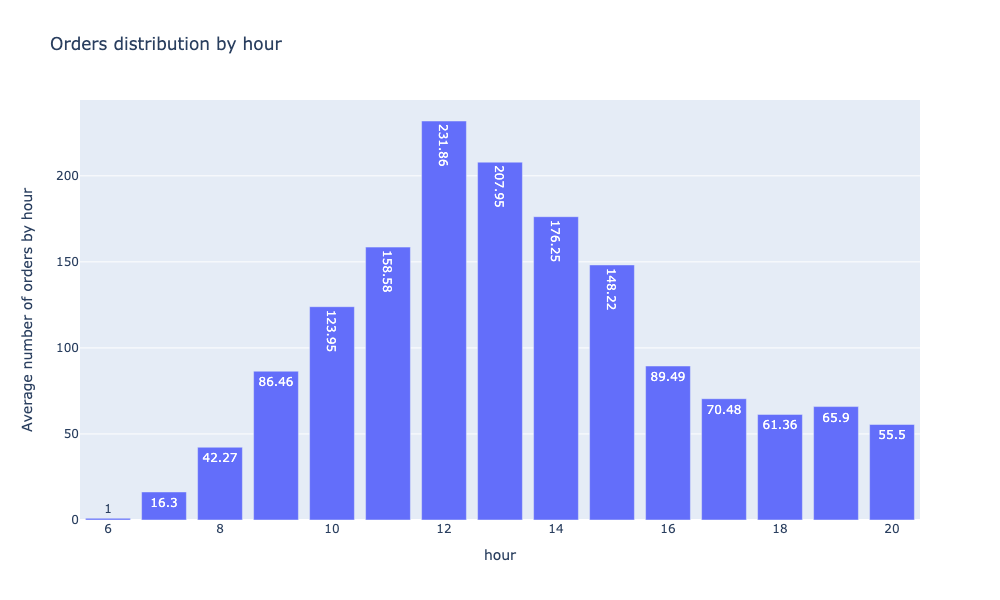

In [58]:
data['date'] = data['InvoiceDate'].dt.date
data_date_hour = data.groupby(['date', 'hour'], as_index=False)['InvoiceNo'].agg('count')
data_hour = data_date_hour.groupby('hour')['InvoiceNo'].agg('mean').round(2)

fig = px.bar(
    data_hour,
    width=1000,
    height=600,
    title='Orders distribution by hour',
    text_auto=True
).update_layout(
    yaxis_title='Average number of orders by hour',
    showlegend=False
)
fig.show('png')

The following is correct:
* Most orders are made in the evening in the interval from 10 to 15 hours
* No orders are received from 21:00 pm to 6:00 am (not inclusive)

## 5. RFM-customer segmentation: part 1

We have reached the most interesting part of our task. We need to form the features based on which we will segment our customers.

To do this, let's get acquainted with a very popular method for analyzing customer value called RFM.

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

The method consists of grouping customers based on the following parameters:

* Recency — how long ago the customer made their last purchase;
* Frequency — the total number of customer purchases;
* Monetary Value — how much money the customer spent.

The essence of RFM analysis is that we divide all customers into groups depending on how long ago they made their last purchase, how often they bought, and how large their order amount was.

For example, this is how cluster interpretation may look for the case of RF segmentation (analysis based on the recency and frequency of customer orders, in Russian):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

The task of marketers is to lead the client to the loyal zone.

We can calculate RFM characteristics for each of the clients in our dataset and, based on them, using clustering methods, build similar client segments tied to our data.

### Task 5.1

So, let's start creating our RFM table.

To get the RFM table, we need to group the data by customer IDs and calculate the following aggregated characteristics:

* Recency for the i-th customer is calculated as the difference between the date and time of the last order and the reference point, converted into days:
$$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

where $t_{ij}$ is the date and time when the i-th customer made his j-th purchase.

As the reference point $t_0$, we take the date one day "younger" than all our data. This will be December 10, 2011 (in datetime format - '2011-12-10 00:00:00').

* Frequency is calculated as the total number of unique orders made by the i-th customer.
* Monetary Value is calculated as the total amount of money the i-th customer spent on our products (including returns).

Once you have calculated all the characteristics, do not forget to give the columns of the resulting table the appropriate names.

In [79]:
rfm = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False).agg(
    {
        'InvoiceDate': 'max',
        'total_price': 'sum'
    }
)
rfm = rfm.groupby('CustomerID').agg(
    Recency=('InvoiceDate', 'max'),
    Frequency=('InvoiceNo', 'count'),
    Monetary=('total_price', 'sum')
)
reference_point = pd.to_datetime('2011-12-10 00:00:00')
rfm['Recency'] = (reference_point - rfm['Recency']).dt.days

print('Calculated RFM:')
rfm.head(5)


Calculated RFM:


,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


1) How many customers made a purchase more than 200 days ago?

2) How many orders does a customer make on average (over the given annual period)? Round your answer to the nearest whole number.

3) What is the total amount spent by customer ID 12360? Give your answer in pounds sterling and round it to the nearest whole number.

In [100]:
# 1
print('Number of customers withlast purchases longer than 200 days ago:', rfm[rfm['Recency'] > 200].shape[0])

# 2
print('Average amount of orders per customer:', rfm['Frequency'].mean().round())

# 3
rfm_customer = rfm.reset_index()
print(
    'Total amount spent by the customer 12360:', 
    rfm_customer[rfm_customer['CustomerID'] == 12360]['Monetary'].iloc[0].round()
)

Number of customers withlast purchases longer than 200 days ago: 743
Average amount of orders per customer: 4.0
Total amount spent by the customer 12360: 2302.0


Now let's look at the boxplots for each of the features:

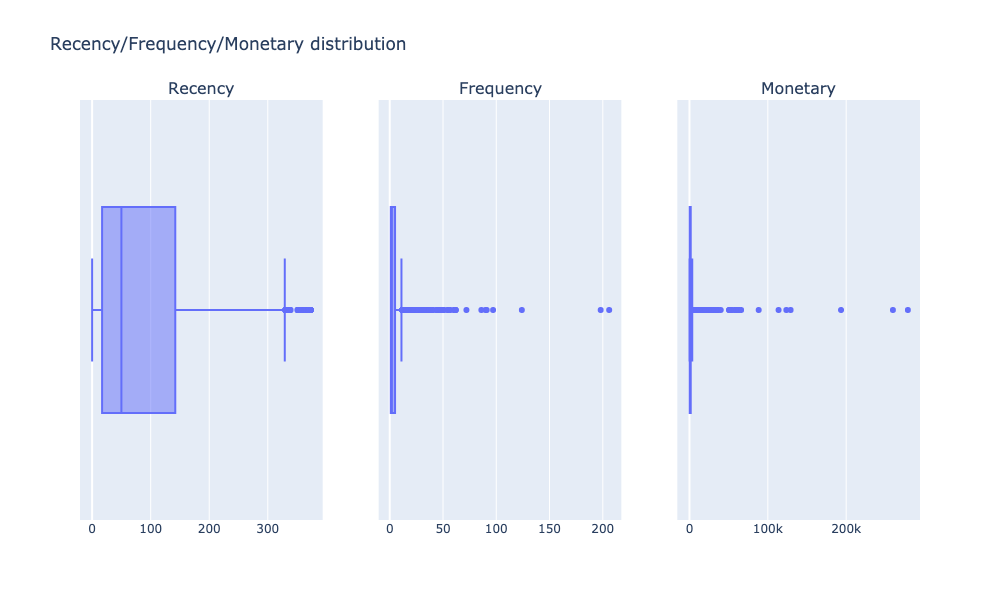

In [108]:
boxes = [px.box(rfm, x=column) for column in rfm.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(
    width=1000,
    height=600,
    title='Recency/Frequency/Monetary distribution'
)
fig.write_html('boxplot_1.html')
fig.show('png')

What's interesting to see here? There are customers with an abnormally large number of orders (more than 100), as well as customers whose total order value exceeds £190,000.

Why is this bad? Outliers can negatively affect the results of clustering methods that are not robust to them, such as the KMeans algorithm, so we would like to get rid of them. However, we also don't want to lose a lot of valuable customer data, so we limit ourselves to the upper limit of the corresponding quantile of 0.95. This way, we will remove data from those customers for whom the Frequency parameter or the Monetary parameter is higher than 95% of customers.

### Task 5.2
Delete from the RFM table the records about clients for whom at least one of the conditions is met:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$

where $frequency_{0.95}$ and $monetary_{0.95}$ are the quantiles of the 0.95 level for the corresponding features.

How many clients do you have data about left in the RFM table?

In [112]:
frequence_quantile_95 = rfm['Frequency'].quantile(0.95)
monerary_quantile_95 = rfm['Monetary'].quantile(0.95)
print('Frequency quantile 95 %:', frequence_quantile_95)
print('Monetary quantile 95 %:', monerary_quantile_95.round(2))

rfm_wo_outliers = rfm[rfm['Frequency'] <= frequence_quantile_95]
rfm_wo_outliers = rfm_wo_outliers[rfm_wo_outliers['Monetary'] <= monerary_quantile_95]

print('Number of customers without outliers:', rfm_wo_outliers.shape[0])

Frequency quantile 95 %: 13.0
Monetary quantile 95 %: 5659.85
Number of customers without outliers: 4044


After removing outliers, we get the following boxplots:

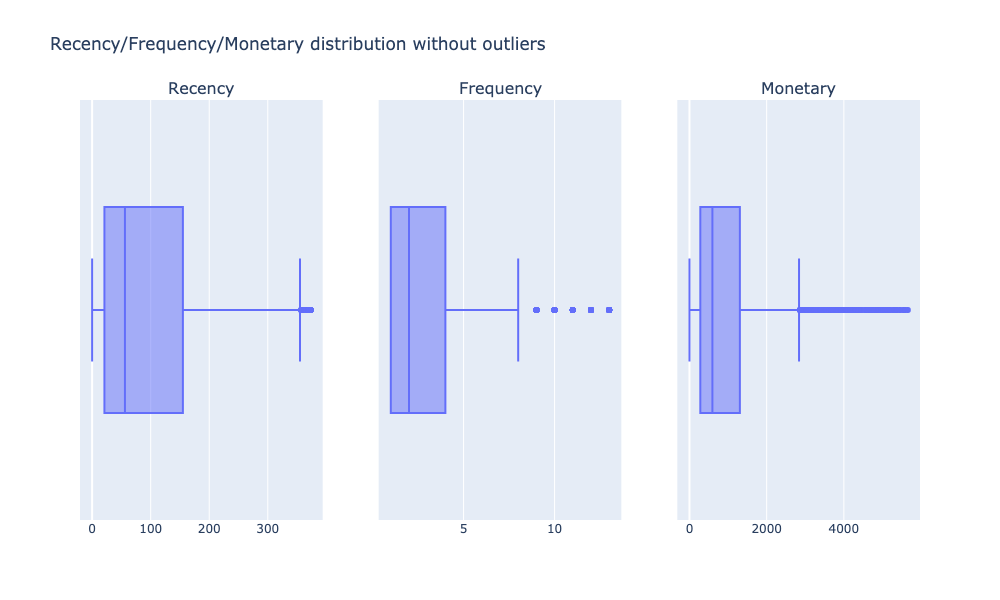

In [136]:
boxes = [px.box(rfm_wo_outliers, x=column) for column in rfm_wo_outliers.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(
    width=1000,
    height=600,
    title='Recency/Frequency/Monetary distribution without outliers'
)
fig.write_html('boxplot_2.html')
fig.show('png')

We finally got to the clustering stage. First, we need to estimate how the observations are distributed in the feature space. Fortunately, we only have three parameters by which we want to cluster customers, so the data can be visualized as a 3D scatterplot.

Let's build a visualization of our 3D feature space:

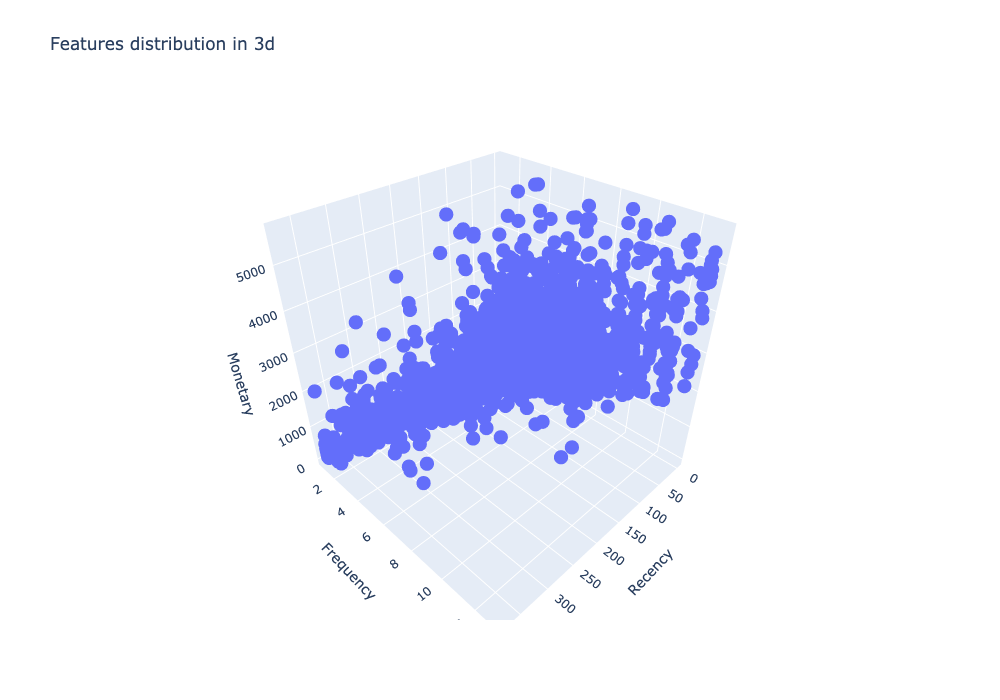

In [125]:
fig = px.scatter_3d(
    rfm_wo_outliers,
    x='Recency',
    y='Frequency',
    z='Monetary',
    width=1000,
    height=700,
    title='Features distribution in 3d'
)
fig.show('png')

What can we see here? Nothing specific, really. Yes, we can see that there are clients with high values ​​of the Monetary and Frequency parameters — these are probably the best clients, who buy most often and bring in the most money. However, it is difficult to tell from the total mass of points how many clusters we have — rather, it seems that the space is not amenable to clustering.

Let's call on dimensionality reduction methods to help.

### Task 5.3
Let's start with the principal component analysis (PCA). We know that for it to work stably, the data needs to be standardized/normalized.

For convenience, let's wrap these data preprocessing steps in a pipeline.

Create a pipeline that has the following steps:
* standardization using StandardScaler with default parameters;
* principal component analysis with two components.

Train your pipeline on the RFM table cleared of outliers and apply the transformation to it.

What ratio of the variance in the original data does the first principal component explain? Round your answer to two decimal places.

In [134]:
pl = pipeline.Pipeline(
    [
        ('scaler', preprocessing.StandardScaler()),
        ('pca', decomposition.PCA(n_components=2))
    ]
)
rfm_scaled_reduced = pl.fit_transform(rfm_wo_outliers)
print('Variance ratio of the first principal component:', pl['pca'].explained_variance_ratio_[0].round(2))

Variance ratio of the first principal component: 0.68


Visualizing the space of principal components after decomposition, we get the following figure:

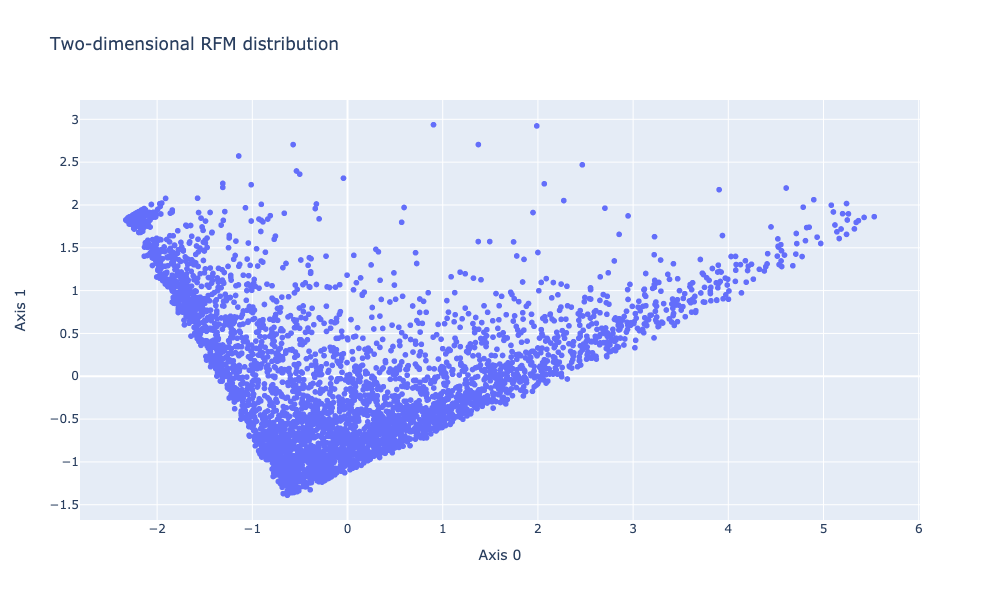

In [143]:
fig = px.scatter(
    rfm_scaled_reduced, 
    x=0, 
    y=1,
    width=1000,
    height=600,
    title='Two-dimensional RFM distribution'
).update_layout(
    xaxis_title='Axis 0',
    yaxis_title='Axis 1'
)
fig.show('png')

Let's try to divide this space of principal components into segments.

### Task 5.4
Let's try using the k-means method.

Select the optimal number of clusters for the k-means method using the silhouette coefficient, going through possible values ​​from 2 to 10 inclusive.

Take the number 42 as the value of the random_state parameter. Leave the other parameters by default.

1) Based on the results obtained, what number of clusters is best to take?

2) What is the maximum value of the silhouette coefficient? Round your answer to two digits after the separator.

In [145]:
for n_clust in range(2, 11):
    km = cluster.KMeans(n_clusters=n_clust, random_state=42)
    km.fit(rfm_scaled_reduced)
    print(
        f'Clusters: {n_clust}, Silhouette score: {metrics.silhouette_score(rfm_scaled_reduced, km.labels_).round(2)}'
    )

Clusters: 2, Silhouette score: 0.5
Clusters: 3, Silhouette score: 0.52
Clusters: 4, Silhouette score: 0.5
Clusters: 5, Silhouette score: 0.45
Clusters: 6, Silhouette score: 0.45
Clusters: 7, Silhouette score: 0.42
Clusters: 8, Silhouette score: 0.42
Clusters: 9, Silhouette score: 0.41
Clusters: 10, Silhouette score: 0.4


1) Best number of clusters to take is 3.

2) The maximum vaue of the silhouette coefficient is 0.52.

### Task 5.5
Now let's take the EM algorithm.

Select the optimal number of clusters for the EM algorithm (GaussianMixture) using the silhouette coefficient, going through possible values ​​from 2 to 10 inclusive.
Take the number 42 as the value of the random_state parameter. Leave the other parameters by default.

1) Judging by the results obtained, what number of clusters is best to take?

2) What is the maximum value of the silhouette coefficient? Round the answer to two digits after the separator.

In [149]:
for n_clust in range(2, 11):
    gm = mixture.GaussianMixture(n_components=n_clust, random_state=42)
    labels_ = gm.fit_predict(rfm_scaled_reduced)

    print(
        f'Clusters: {n_clust}, Silhouette score: {metrics.silhouette_score(rfm_scaled_reduced, labels_).round(2)}'
    )

Clusters: 2, Silhouette score: 0.34
Clusters: 3, Silhouette score: 0.44
Clusters: 4, Silhouette score: 0.35
Clusters: 5, Silhouette score: 0.25
Clusters: 6, Silhouette score: 0.27
Clusters: 7, Silhouette score: 0.2
Clusters: 8, Silhouette score: 0.2
Clusters: 9, Silhouette score: 0.16
Clusters: 10, Silhouette score: 0.11


1) Best number of clusters to take is 3.

2) The maximum vaue of the silhouette coefficient is 0.44.

### Task 5.6
Let's look at the distribution of clusters.

1) First, we need to determine the best model. For which model with the optimal number of clusters is the silhouette coefficient the largest?
* K-Means
* GaussianMixture

2) Train the best model with the previously selected number of clusters on the decomposed data.

How many clients were in the largest cluster?

In [153]:
km = cluster.KMeans(n_clusters=3, random_state=42)
km.fit(rfm_scaled_reduced)
labels_ = pd.Series(km.labels_)
print('Number of customers in the largest cluster:', labels_.value_counts().iloc[0])

Number of customers in the largest cluster: 2269


1) K-Means showed a better silhouette coefficient 0.52 compared to 0.44 with GaussianMixture.

2) Number of customers in the largest cluster: 2269.

Визуализируем результаты кластеризации:

In [ ]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels,
);

Итак, у нас есть три сегмента клиентов. Давайте попробуем составить профиль для этих сегментов.

### Задание 5.7

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.

Чему равно максимальное среднее значение признака Frequency в полученной таблице? Ответ округлите до целого числа.

### Полярная диаграмма
Сейчас мы познакомимся с одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме мы видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализовали собственную функцию plot_cluster_profile(), которая позволяет визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией мы также добавили в реализацию функции plot_cluster_profile().

In [ ]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков
    features = grouped_data.columns
    # Создаем пустую фигуру
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру
    fig.show()
    

Теперь у нас есть удобный инструмент для анализа профиля кластеров. Давайте воспользуемся им.


### Задание 5.8

Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

Описание кластера:
* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «промежуточным» клиентам, которые являются активными, но покупают не так часто и много, как лояльные клиенты. В то же время эти клиенты не являются «потерянными».
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена очень давно.


### 4. RFM-сегментация клиентов: часть 2

Итак, с помощью RFM-анализа нам удалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, мы вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. Вспомним, что PCA является линейным методом отображения исходного пространства признаков в его сжатую версию.

А что если использовать нелинейную трансформацию? Например, алгоритм снижения размерности t-SNE. Давайте попробуем и посмотрим, что получится.

### Задание 6.1
Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Давайте для удобства обернём шаги по предобработке данных в pipeline.

Создайте pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучите ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и примените к ней трансформацию.

Чему равно значение дивергенции Кульбака — Лейблера для обученного алгоритма t-SNE? Ответ округлите до двух знаков после точки-разделителя.

**Примечание:**
Напомним, что дивергенция Кульбака-Лейблера - это функция потерь, которая минимизируется при обучения алгоритма t-SNE. Она показывает меру расстояния между двумя распределениями. 

Оптимальное значение данной характеристики, найденное в процессе обучения алгоритма t-SNE, хранится в атрибуте kl_divergence_ объекта класса TSNE из библиотеки sklearn. Конечно же, предварительно модель необходимо обучить, чтобы получить это значение.



Визуализировав пространство после декомпозиции с помощью t-SNE, мы получим следующую картину:


In [ ]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь давайте воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.


### Задание 6.2
Попробуем воспользоваться методом k-means. 
Подберите оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



### Задание 6.3
Попробуем воспользоваться EM-алгоритом. 

Подберите оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.

### Задание 6.4
Наконец, попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберите оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставьте по умолчанию.


1) Судя по полученным результатам, какое количество кластеров лучше всего взять?

2) Чему равно максимальное значение коэффициента силуэта? Ответ округлите до двух знаков после точки-разделителя.



### Задание 6.5
Давайте посмотрим на распределение кластеров.

1) Сначала нужно определить лучшую модель. Для какой модели с оптимальным количеством кластеров коэффициент силуэта наибольший?
* K-Means
* GaussianMixture
* AgglomerativeClustering


2) Обучите лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 
Сколько клиентов попало в самый большой кластер?



Визуализируем результаты кластеризации:

In [ ]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=model.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Давайте попробуем составить профиль для этих сегментов. 


### Задание 6.6

Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируйте RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков. Для наглядности округлите все значения в столбцах до целого числа.

Чему равно максимальное среднее значение признака Recency в полученной таблице? Ответ округлите до целого числа.

### Задание 6.7
Визуализируйте профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

Проанализируйте кластеры и на основе анализа сопоставьте номер кластера и его описание.

* Кластер соответствует «лояльным» клиентам, которые приносят наибольший доход, совершают покупки чаще всего, а давность их последней покупки наименьшая.
* Кластер соответствует «перспективным» клиентам, которые являются активными покупателями, но покупают не так часто и не так много, как лояльные клиенты.
* Кластер соответствует «подвисшим» клиентам, которые относительно недавно сделали несколько заказов на небольшие суммы. Потенциально эти клиенты могут быть переведены в кластер «перспективных».
* Кластер соответствует клиентам «в зоне риска», которые несколько раз покупали товары на небольшие суммы, однако их последняя покупка была совершена более пяти месяцев назад.
* Кластер соответствует клиентам-«новичкам», которые относительно недавно сделали один заказ на небольшую сумму. 
* Кластер соответствует «спящим» или «почти потерянным» клиентам, которые сделали один заказ на маленькую сумму более семи месяцев назад и больше не возвращались.
* Кластер соответствует «потерянным» клиентам, которые купили меньше всего товара, и их последняя покупка была совершена около года назад.



## 7. RFM-кластеризация клиентов: часть 3

Мы построили модель кластеризации для части клиентов.Но как сделать предсказание сегмента для клиентов, которые не попали в обучающую выборку?

Вы, вероятно, скажете: «Воспользоваться методом predict()!»

Верно, однако всё не так просто.

Вспомним, что мы обучали наши алгоритмы кластеризации на сжатом с помощью t-SNE пространстве признаков. То есть, чтобы сделать предсказание для новых объектов, не попавших в выборку, нам необходимо будет совершить трансформацию признаков этих объектов в новое сжатое пространство. 

Однако проблема t-SNE заключается в том, что алгоритм непараметрический. Это значит, что он, в отличие от таких алгоритмов, как PCA и SVD, не создаёт явной функции отображения. Проще говоря, алгоритм трансформирует пространство признаков для обучающей выборки, но не запоминает, каким образом это делает. Это значит, что, передав в алгоритм новые объекты для сжатия пространства, мы получим абсолютно новое представление пространства, не имеющее отношения к тому, что мы построили для обучающей выборки. То есть произойдёт искажение, что может привести к неверным результатам кластеризации.

Именно поэтому у класса TSNE из библиотеки sklearn нет такого метода, как transform(), у него есть только метод fit_transform() — заново обучить алгоритм t-SNE и произвести трансформацию.

Как же тогда производить кластеризацию для новых объектов, если мы не можем сжимать размерность для новых данных?

Давайте сведём задачу кластеризации к задаче классификации. Действительно, у нас теперь есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Давайте обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

### Задание 7.1

Разделите исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмите число 42.

Сколько клиентов попали в тестовую выборку?

Дальше нам осталось только построить несколько моделей и выбрать из них лучшую. 
Мы знаем, что алгоритм t-SNE является нелинейным методом понижения размерности. Можно смело предположить, что линейные модели, такие как логистическая регрессия, в данной задаче нам мало чем помогут (можете убедиться в этом самостоятельно, обучив модель логистической регрессии на тренировочной выборке и оценив качество на тестовой).

Поэтому давайте сразу возьмём тяжелую артиллерию — ансамблевые алгоритмы. 


### Задание 7.2
Начнём со случайного леса. С помощью GridSearchCV организуйте перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5.

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в случайном лесу?

2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



Итак, значение метрики accuracy очень высокое, но не идеальное. Давайте попробуем его улучшить, воспользовавшись бустингом.

### Задание 7.3
С помощью GridSearchCV организуйте перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используйте число 42.
В качестве метрики используйте accuracy. Количество фолдов для кросс-валидации — 5. 

1) Обучите GridSearchCV на тренировочной выборке. Чему равна оптимальная максимальная глубина деревьев в градиентном бустинге?
Ответ: 6
2) С помощью лучшей модели сделайте предсказание для тестовой выборки и рассчитайте метрику accuracy. Ответ округлите до трёх знаков после точки-разделителя.



Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.